<a href="https://colab.research.google.com/github/silviutroscot/Machine-Learning-Playground/blob/master/Vanilla_Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt

from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def show_torch_image(torch_tensor):
    plt.imshow(torch_tensor.numpy().reshape(28, 28), cmap='gray')
    plt.show()

In [0]:
#Load dataset
train = pd.read_csv("gdrive/My Drive/Datasets/fashion-mnist_train.csv")

#normalization and preprocessing
X = train.iloc[:,1:].values / 255
X = (X-0.5)/0.5

Y = train.iloc[:,0].values

print(X.shape,Y.shape)
# check that the normalization was correct and the values are in range [-1,1]
print (np.max(X))
print (np.min(X))

(60000, 784) (60000,)
1.0
-1.0


In [0]:
# split data into training and test data
trn_x, test_x, trn_y, test_y = train_test_split(X,Y,test_size=0.20)

In [0]:
# convert the numpy training and test arrays to torch tensors
trn_x_torch = torch.from_numpy(trn_x).type(torch.FloatTensor)
trn_y_torch = torch.from_numpy(trn_y)

test_x_torch = torch.from_numpy(test_x).type(torch.FloatTensor)
test_y_torch = torch.from_numpy(test_y)

trn = TensorDataset(trn_x_torch, trn_y_torch)
test = TensorDataset(test_x_torch, test_y_torch)

trn_dataloader = torch.utils.data.DataLoader(trn, batch_size=100,shuffle=False, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=100,shuffle=False, num_workers=4)

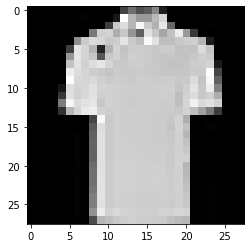

In [0]:
show_torch_image(trn_x_torch[1])

In [0]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        #encoder
        self.e1 = nn.Linear(784,28)
        self.e2 = nn.Linear(28,250)
        
        #Latent View
        self.lv = nn.Linear(250,10)
        
        #Decoder
        self.d1 = nn.Linear(10,250)
        self.d2 = nn.Linear(250,500)
        
        self.output_layer = nn.Linear(500,784)
        
    def forward(self,x):
        x = F.relu(self.e1(x))
        x = F.relu(self.e2(x))
        
        x = torch.sigmoid(self.lv(x))
        
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        
        x = self.output_layer(x)
        return x

In [0]:
ae = AutoEncoder()
print(ae)

AutoEncoder(
  (e1): Linear(in_features=784, out_features=28, bias=True)
  (e2): Linear(in_features=28, out_features=250, bias=True)
  (lv): Linear(in_features=250, out_features=10, bias=True)
  (d1): Linear(in_features=10, out_features=250, bias=True)
  (d2): Linear(in_features=250, out_features=500, bias=True)
  (output_layer): Linear(in_features=500, out_features=784, bias=True)
)


In [0]:
#define our optimizer and loss function
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

In [0]:
losses = []
EPOCHS = 5
for epoch in range(EPOCHS):
    
    for batch_idx, (data,target) in enumerate(trn_dataloader):
        
        data = torch.autograd.Variable(data)
    
        
        optimizer.zero_grad()
        
        pred = ae(data)
        
        loss = loss_func(pred, data)
        
        losses.append(loss.cpu().data.item())
        
        # Backpropagation
        loss.backward()
        
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(trn_dataloader.dataset),
                100. * batch_idx / len(trn_dataloader), 
                loss.cpu().data.item()), 
                end='')

 Train Epoch: 5/5 [40100/48000 (84%)]	Loss: 0.061583

In [0]:
# set the model to evaluation mode
ae.eval()
predictions = []

for batch_idx, (data,target) in enumerate(test_dataloader):
        
        data = torch.autograd.Variable(data)

        pred = ae(data)
        
        for prediction in pred:
            predictions.append(prediction)
            
        
        
len(predictions)   

12000

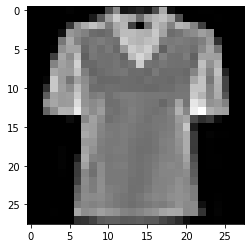

784


In [0]:
show_torch_image(test_x_torch[0])
print(len(test_x_torch[0]))

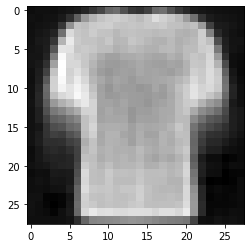

784


In [0]:
show_torch_image(predictions[0].detach())
print(len(predictions[0]))

In [0]:
# algorithms for evaluating the accuracy of the reconstruction of our AE
# compute the sum of the differences between the initial representation and the learnt representation

def meanSquaredError(test_x_torch, predictions):
    diffList = [] 
    for i in range(0, len(predictions)):
        diff = test_x_torch[i] - predictions[i]
        squared_diff = torch.mul(diff, diff)
        squared_diff_mean = squared_diff.mean()
        diffList.append(squared_diff_mean)
    
    diffList = torch.tensor(diffList)
    return diffList.mean()

In [0]:
MSerror =  meanSquaredError(test_x_torch, predictions)
print (MSerror)

tensor(0.0620)
